# A Tutorial In Fitting CARMA Models to Time-Series Data

Some preliminary imports:

In [1]:
push!(LOAD_PATH, ".")

3-element Array{ByteString,1}:
 "/Users/farr/Documents/code/julia/usr/local/share/julia/site/v0.4"
 "/Users/farr/Documents/code/julia/usr/share/julia/site/v0.4"      
 "."                                                               

In [71]:
using Colors
using Ensemble
using Gadfly
using Kalman

For an introduction to CARMA models, see [Kelly, et al (2014)](http://arxiv.org/abs/1402.5978) and the forthcoming Barrett & Farr (in prep).  Note that the software associated with Kelly, et al (2014), [carma_pack](https://github.com/brandonckelly/carma_pack), which is similar to that presented here, has some bugs that we have not yet tracked down.

## Example 1: Time-Series Measurements from [XB158](http://arxiv.org/abs/1501.01978)

The X-Ray Binary XB158 in M31 (Andromeda) has a $2.78 \, \mathrm{hr}$ orbital period.  Theoretical calculations suggest that the accretion disk in this binary should precess on a much longer timescale.  [Barnard, et al (2015)](http://arxiv.org/abs/1501.01978) looked for such precession is Swift data, and found a $5.65 \pm 0.05 \, \mathrm{d}$ oscillation in the $0.3$--$10\, \mathrm{kev}$ channel.  Can we also find oscillations in the data using a CARMA model?

The file `XB158Intensity.dat` has three columns, giving time (in days), flux (counts per second), and a 1-sigma uncertainty on the flux.

In [3]:
xb158i = readdlm("XB158Intensity.dat")

30x3 Array{Float64,2}:
  0.0  0.0255148   0.00337951
  0.9  0.0163347   0.00255105
  2.0  0.00565463  0.00156831
  3.0  0.0173989   0.002751  
  3.1  0.017276    0.00263457
  4.4  0.0252722   0.00313463
  5.4  0.0203106   0.00284406
  6.4  0.0216319   0.00286521
  7.3  0.0117124   0.00217495
  8.8  0.0147504   0.00236195
  9.5  0.0220374   0.00302707
 10.1  0.0171863   0.00262088
 11.2  0.0190931   0.00275585
  ⋮                          
 17.1  0.0225904   0.00336757
 18.1  0.00935925  0.00259579
 19.4  0.00669145  0.00157719
 20.2  0.0156366   0.00241279
 21.1  0.0230415   0.00285794
 22.3  0.0188041   0.0026593 
 23.2  0.0169679   0.00250178
 24.3  0.0127737   0.00215915
 25.1  0.00742574  0.00175026
 26.1  0.0192157   0.0027451 
 27.2  0.0233756   0.00304324
 28.4  0.017589    0.00274694

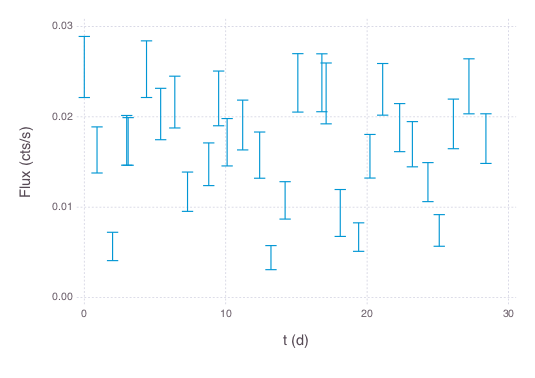

In [5]:
plot(x=xb158i[:,1], y=xb158i[:,2], ymax=xb158i[:,2]+xb158i[:,3], ymin=xb158i[:,2]-xb158i[:,3], Geom.errorbar, Guide.xlabel("t (d)"), Guide.ylabel("Flux (cts/s)"))

There is no obvious pattern in the data, though it is certainly possible to imagine that the data have a 5-day period.  If we want to find an oscillation, then we should choose a CARAMA model with at least $p=2$ (oscillations will correspond to complex roots in the denominator of the power spectrum, and therefore we need at least two roots for the two complex-conjugates).  I prefer to allow at least one additional real root in the denominator, and to choose the MA roots for maximum flexibility consistent with a stationary process, so I usually choose $q = p - 1$.  Thus, let's try a $p=3$, $q=2$ model on this data:

In [6]:
p = 3
q = 2
# We construct the posterior object by giving it times, samples, and uncertainties.
posterior = Kalman.CARMAKalmanPosterior(xb158i[:,1], xb158i[:,2], xb158i[:,3], p, q)

Kalman.CARMAKalmanPosterior([0.0,0.9,2.0,3.0,3.1,4.4,5.4,6.4,7.3,8.8  …  19.4,20.2,21.1,22.3,23.2,24.3,25.1,26.1,27.2,28.4],[0.0255148,0.0163347,0.00565463,0.0173989,0.017276,0.0252722,0.0203106,0.0216319,0.0117124,0.0147504  …  0.00669145,0.0156366,0.0230415,0.0188041,0.0169679,0.0127737,0.00742574,0.0192157,0.0233756,0.017589],[0.00337951,0.00255105,0.00156831,0.002751,0.00263457,0.00313463,0.00284406,0.00286521,0.00217495,0.00236195  …  0.00157719,0.00241279,0.00285794,0.0026593,0.00250178,0.00215915,0.00175026,0.0027451,0.00304324,0.00274694],3,2)

We have had good luck using nested sampling to explore the posteiors on the CARMA parameters, so let's use that.  We need to construct the initial ensemble of points, drawn from the prior, and then create a `NestState` to represent the sampling.  We will use 1024 live points, ensuring that we have at least $\mathcal{O}(1000)$ posterior samples:

In [9]:
nlive = 1024
prior_pts = Kalman.init(posterior, nlive)

8x1024 Array{Float64,2}:
  0.0710414    0.0330215    0.0641068  …  -0.0120679     0.0519298
  0.00304248   0.00474914   0.0431979      0.000648841   0.0400782
  1.07398      0.495826     0.624861       5.552         0.291829 
  1.95453      2.00581     -0.801335      -0.590075      1.19397  
  2.22561      0.079567    -2.87931        1.20188       0.308781 
  1.49675     -0.732728    -1.20511    …   1.21632      -0.993011 
  2.08598      2.16831     -1.02522        0.0379295     1.15086  
 -0.315911     3.8969       0.969844       3.76224      -1.45635  

When constructing the nested sampling state, we need to give it an initial guess as to how many MCMC steps to take to generate the next live point; a good initial guess is typically $\mathcal{O}(100)$.

In [10]:
neststate = EnsembleNest.NestState(x -> Kalman.log_likelihood(posterior, x), x->Kalman.log_prior(posterior, x), prior_pts, 128)

Ensemble.EnsembleNest.NestState((anonymous function),(anonymous function),128,128.0,8x1024 Array{Float64,2}:
  0.0710414    0.0330215    0.0641068  …  -0.0120679     0.0519298
  0.00304248   0.00474914   0.0431979      0.000648841   0.0400782
  1.07398      0.495826     0.624861       5.552         0.291829 
  1.95453      2.00581     -0.801335      -0.590075      1.19397  
  2.22561      0.079567    -2.87931        1.20188       0.308781 
  1.49675     -0.732728    -1.20511    …   1.21632      -0.993011 
  2.08598      2.16831     -1.02522        0.0379295     1.15086  
 -0.315911     3.8969       0.969844       3.76224      -1.45635  ,[5.72371,6.05132,3.61219,2.63587,7.04199,7.11653,3.38639,5.87944,7.15665,6.39486  …  6.39325,5.45038,7.18471,5.44014,3.87438,4.46436,6.84451,5.34414,5.62616,4.44851],[-3160.68,-115.695,-9.30762,-24.8993,-2905.37,-19672.7,16.0665,-83.6574,-1508.87,-82.568  …  -1833.32,21.6922,-13547.8,-459.349,56.1811,48.3971,-561.68,-50.0652,38.9342,58.5044],8x0 Array{F

Now we run the nested sampling, and we terminate the run when the uncertainty in the log-evidence is 0.1.  The sampler is very verbose by default; to turn that off, pass a third argument `false` to the `run!` method.

In [13]:
@time EnsembleNest.run!(neststate, 0.1)

Retired point with ll = -184323.5688508874; accept = 0.21875; next nmcmc = 128
Retired point with ll = -151068.98986177437; accept = 0.1953125; next nmcmc = 128
Retired point with ll = -146195.96806256098; accept = 0.171875; next nmcmc = 128
Retired point with ll = -130111.6886861883; accept = 0.125; next nmcmc = 128
Retired point with ll = -86988.20841160804; accept = 0.2109375; next nmcmc = 128
Retired point with ll = -64271.83997366332; accept = 0.0546875; next nmcmc = 128
Retired point with ll = -60375.91033400628; accept = 0.2109375; next nmcmc = 128
Retired point with ll = -47655.06232529287; accept = 0.1015625; next nmcmc = 128
Retired point with ll = -44613.061340903885; accept = 0.1015625; next nmcmc = 128
Retired point with ll = -43390.68033031367; accept = 0.15625; next nmcmc = 128
Retired point with ll = -42515.96001881634; accept = 0.1171875; next nmcmc = 128
Retired point with ll = -34994.916596488205; accept = 0.0703125; next nmcmc = 128
Retired point with ll = -33933.56

In [14]:
println("log(Z) for the (3,2) model is $(EnsembleNest.logZ(neststate))")

log(Z) for the (3,2) model is 110.02383261799561


Let's just check that the log-likelihood surface doesn't have any strange behaviours:

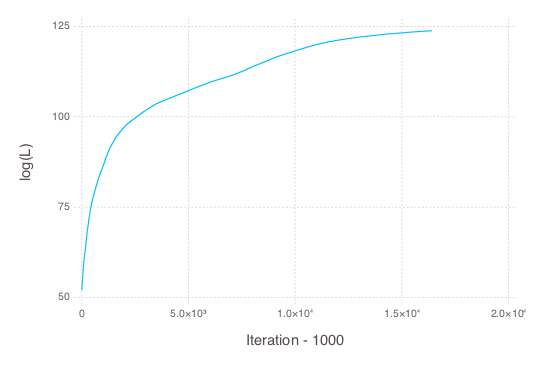

In [18]:
plot(y=neststate.deadlogls[1000:end], Geom.line, Guide.xlabel("Iteration - 1000"), Guide.ylabel("log(L)"))

Let's extract some posterior samples from the sampling:

In [19]:
postsamples32 = EnsembleNest.postsample(neststate)

8x4766 Array{Float64,2}:
  0.0148667   0.0162156    0.0154912   …   0.0167912    0.0166835
  0.0108066   0.00470554   0.00418048      0.00641709   0.0058952
  1.67532     0.132008     2.20077         0.702768     0.462228 
 -0.574443    2.33186      1.40691        -2.40756     -2.08905  
  0.598651    3.96572      2.11269         0.21133      0.216981 
  1.25678     0.356307     2.10041     …   0.871958     1.04165  
  1.77167     0.282708    -2.58036        -2.41563     -0.121563 
  3.45106    -0.623927     1.93466        -5.04111     -1.41914  

Now, we can plot the posterior on the PSD of the CARMA process.  Here we face a choice about how to choose the range of frequencies we are interested in.  I typically choose the range outlined below, but adapt based on the physics of the data set I am trying to extract:

In [22]:
fmax = 1.0/(2*median(diff(xb158i[:,1]))) # As if median dt were Nyquist
df = 1.0/(xb158i[end,1]-xb158i[1,1]) # With spacing equal to 1/T
fs = collect(df:df:fmax)
psds = zeros(size(fs, 1), 1000)
for i in 1:1000
    p = postsamples32[:, rand(1:size(postsamples32,2))] # Choose a random posterior sample
    psds[:,i] = Kalman.psd(posterior, p, fs)
end

We would like to plot the median and +/- 1-sigma quantiles of the PSD

In [26]:
pmin = zeros(size(fs, 1))
pmax = zeros(size(fs, 1))
pmed = zeros(size(fs, 1))
for i in 1:size(fs, 1)
    pmin[i] = quantile(vec(psds[i,:]), 0.16)
    pmed[i] = median(vec(psds[i,:]))
    pmax[i] = quantile(vec(psds[i,:]), 0.84)
end

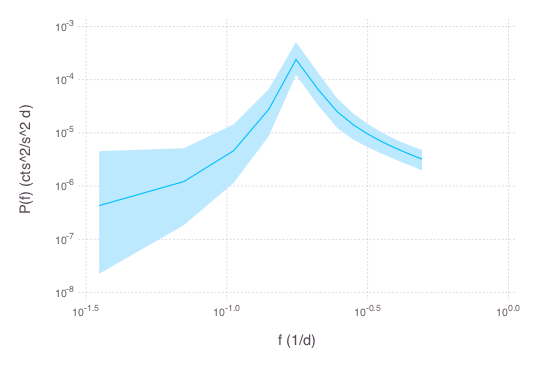

In [28]:
plot(layer(x=fs, y=pmed, Geom.line), layer(x=fs, ymax=pmax, ymin=pmin, Geom.ribbon), Scale.x_log10, Scale.y_log10, Guide.xlabel("f (1/d)"), Guide.ylabel("P(f) (cts^2/s^2 d)"))

So there is clearly a peak in the power spectrum, somewhere around 0.2 / day.  Let's plot a posterior on the central frequency of the peak.  To do this, we will extract the complex root of the CARMA process, whose imaginary part is the oscillation frequency:

In [33]:
freqs = Float64[]
for i in 1:size(postsamples32,2)
    p = Kalman.to_params(posterior, postsamples32[:,i])
    arroots = p.arroots
    selector = imag(arroots) .> 0
    if any(selector)
        push!(freqs, imag(arroots[selector][1]/(2.0*pi)))
    end
end
println("$(size(freqs,1)) roots out of $(size(postsamples32, 2)) samples are oscillatory")

4762 roots out of 4766 samples are oscillatory


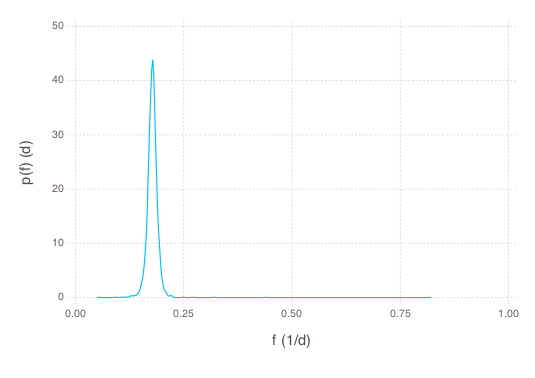

In [34]:
plot(x=freqs, Geom.density, Guide.xlabel("f (1/d)"), Guide.ylabel("p(f) (d)"))

Looks like we need to cut this down a bit---some of the frequencies are outliers.

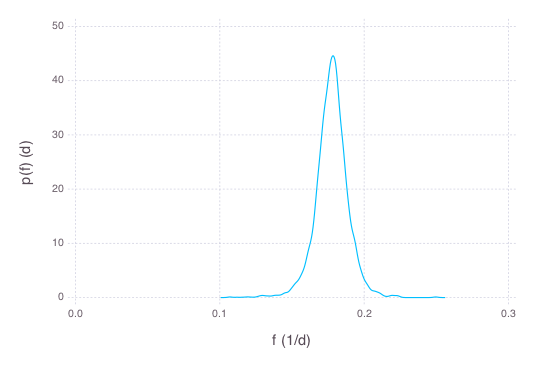

In [44]:
cutfreqs = freqs[(freqs .> 0.1) & (freqs .<0.25)]
plot(x=cutfreqs, Geom.density, Guide.xlabel("f (1/d)"), Guide.ylabel("p(f) (d)"))

In [48]:
println("We find a period P = $(median(1.0./freqs)) + $(quantile(1.0./freqs, 0.84) - median(1.0./freqs)) $(quantile(1.0./freqs, 0.16)-median(1.0./freqs)) days")

We find a period P = 5.625378300941058 + 0.32061798198962244 -0.2837990640424737 days


This is a pretty good match to the claim from Barnard, et al (2015), though with larger uncertainty.  (The Lomb-Scargle periodogram used in that work tends to underestimate the uncertainty with which peaks are identified.)

Another interesting quantity is the inferred quality factor of the oscillation, equal to 
$$
Q \equiv \frac{1}{2\pi} \left| \frac{\mathbb{I}(r)}{\mathbb{R}(r)}\right|
$$
for a complex root, $r$.  The quality factor gives the number of cycles before the stored energy in the oscillation has decayed by $1/e$ (assuming no driving).

In [59]:
Qs = Float64[]
for i in 1:size(postsamples32,2)
    p = Kalman.to_params(posterior, postsamples32[:,i])
    arroots = p.arroots
    selector = imag(arroots) .> 0
    if any(selector)
        push!(Qs, abs(imag(arroots[selector][1]/(2.0*pi))/real(arroots[selector][1])))
    end
end

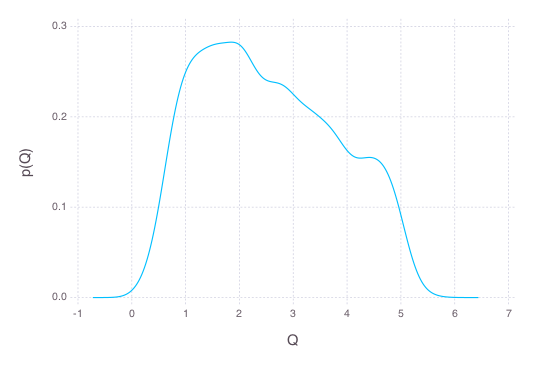

In [61]:
plot(x=Qs, Geom.density, Guide.xlabel("Q"), Guide.ylabel("p(Q)"))

Apparently, we are much less certain about the quality factor of the oscillation.  Note that we will never be able to measure a quality factor much larger than $T/P$ (observation time / period), which for this set of observations is $\sim 5$; you can see above that this is the case.

### Model Selection

Using the `run_carma.jl` program, invoked via `julia run_carma.jl DATAFILE P Q [NLIVE]`, I have also run a $p=5$, $q=4$ model on this data.  Here we will compare the two models using the evidence to assess which might be a better fit to the data.  Beware!  Comparisons via evidences are sensitive to priors on the values of the CARMA roots, so this is somewhat subjective.  You may want to compare via DIC or other information-criterion estimate instead.

I have not put the sampler state file into the Git repo, so if you want to duplicate this section, you will need to run it yourself.

We load the `serialize`d sampler state:

In [67]:
ns54 = open(deserialize, "state-5-4.dat", "r")
post54 = Kalman.CARMAKalmanPosterior(xb158i[:,1], xb158i[:,2], xb158i[:,3], 5, 4)

Kalman.CARMAKalmanPosterior([0.0,0.9,2.0,3.0,3.1,4.4,5.4,6.4,7.3,8.8  …  19.4,20.2,21.1,22.3,23.2,24.3,25.1,26.1,27.2,28.4],[0.0255148,0.0163347,0.00565463,0.0173989,0.017276,0.0252722,0.0203106,0.0216319,0.0117124,0.0147504  …  0.00669145,0.0156366,0.0230415,0.0188041,0.0169679,0.0127737,0.00742574,0.0192157,0.0233756,0.017589],[0.00337951,0.00255105,0.00156831,0.002751,0.00263457,0.00313463,0.00284406,0.00286521,0.00217495,0.00236195  …  0.00157719,0.00241279,0.00285794,0.0026593,0.00250178,0.00215915,0.00175026,0.0027451,0.00304324,0.00274694],5,4)

In [64]:
samp54 = EnsembleNest.postsample(ns54)

12x11489 Array{Float64,2}:
  0.0139383    0.0178545    0.0209336   …   0.0163134    0.0161086 
  0.00559516   0.00800821   0.00658648      0.00511047   0.00503486
  0.250191     1.14893      1.93935         0.340402     0.170717  
  0.642933     1.9559      -1.87839        -2.65182     -2.41879   
  2.39355      1.57966      0.573134        0.230906     0.232413  
  2.14059      2.84795      1.34973     …  -2.40504     -2.25942   
  4.40774      5.09105      3.07833         2.81113      2.81519   
 -1.4243      -2.67453     -1.73674         1.32924      1.14982   
 -2.62819     -0.275935    -0.899734       -0.181115     0.116457  
  0.321805    -0.325575     3.41048         1.73424      3.58143   
 -1.03215      0.0632322    0.493527    …   2.006        1.01813   
 -1.08402      1.09599      0.621733        2.35064      0.757792  

In [65]:
println("(3,2) evidence = $(EnsembleNest.logZ(neststate)); (5,4) evidence = $(EnsembleNest.logZ(ns54))")

(3,2) evidence = 110.02383261799561; (5,4) evidence = 110.7623375380319


Let's look at the PSD from this new model:

In [68]:
psd54 = zeros(size(fs, 1), 1000)
for i in 1:1000
    p = samp54[:,rand(1:size(samp54,2))]
    psd54[:,i] = Kalman.psd(post54, p, fs)
end

In [77]:
pmin54 = zeros(size(fs, 1))
pmax54 = zeros(size(fs, 1))
pmed54 = zeros(size(fs, 1))
for i in 1:size(fs, 1)
    pmin54[i] = quantile(vec(psd54[i,:]), 0.16)
    pmed54[i] = median(vec(psd54[i,:]))
    pmax54[i] = quantile(vec(psd54[i,:]), 0.84)
end

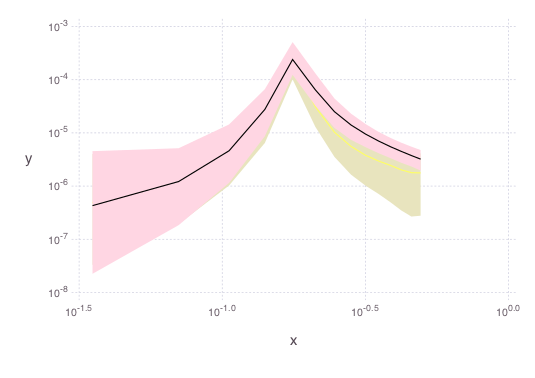

In [79]:
cs = distinguishable_colors(2)
plot(layer(x=fs, y=pmed, Geom.line, Theme(default_color=cs[1])), layer(x=fs, ymax=pmax, ymin=pmin, Geom.ribbon, Theme(default_color=cs[1])),
layer(x=fs, y=pmed54, Geom.line, Theme(default_color=cs[2])), layer(x=fs, ymax=pmax54, ymin=pmin54, Geom.ribbon, Theme(default_color=cs[2])),
Scale.x_log10, Scale.y_log10)

Here we see that the more flexible model returns an essentially identical PSD, but with a bit more uncertainty at high-frequency.  If we extend the range of the frequencies, we would probably see more difference....